# NGUYÊN CỨU THUẬT TOÁN VIDEO LIÊN QUAN CHO THỂ THAO

### Mục Đích (** Objective **)

Hiển thị các video liên quan cũng là một hình thức của **recommendation** (đề xuất). Các video được đề  xuất dựa trên cơ sở nội dung của các video đang hoặc đã được xem trước đó (*item-item base*). Mục tiêu giúp hiển thị cho người xem thấy được các video khác với nội dung tương tự.

### Thuật Toán (Algorithm)

Dựa trên các đặc trưng của một video (title, subtitle, category, country ...) thì video sẽ được thể hiện thông qua 1 vector số học (bước này gọi là embbeding hoặc encoding).
Từ đó có thể tính được khoảng cách (khoảng cách euclidean hoặc cosin) giữa các vector để cho thấy tính gần gũi giữa các video. Từ đó tạo ra các đề xuất cho các video liên quan.

Hiện tại có nhiều hướng xử lí cho bài này ví dụ như sử dụng TF-IDF hoặc BM25 thường dựa vào sự trùng lặp các từ trong mô tả thông để tính toán sắp xếp thứ tự các video liên quan. Thông thường việc tính toán này không liên quan đến ý nghĩa của từ trong mô tả.
Hiện tại, hướng xử lí phổ biến cho các bài toán này là embbeding mô tả dựa trên ngữ nghĩa các thuật toán thường dùng Glove, BERT, ...

#### BERT vs phoBERT

- BERT và các kiến trúc Transformer Encoder đã rất thành công trên nhiều bài toán NLP (xử lí ngôn ngữ tự nhiên). Nó được coi là một nghiên cứu đột phá của Google trong lĩnh vực xử lí ngôn ngữ tự nhiên. 
- BERT đã thu được kết quả tối ưu mới nhất cho 11 nhiệm vụ xử lý ngôn ngữ tự nhiên, bao gồm việc đẩy kết quả của nhiệm vụ GLUE (embedding từ dựa vào ngữ nghĩa) benchmark lên 80.4%(cải tiến thêm 7.6%) và SQuAD v.1.1 với F1 score trên tập test đạt 93.2%(cải tiến thêm 1.5%), tốt hơn con người 2%.
- Tới thời hiện, các mô hình dựa trên kiến trúc này đã được phát triển và cải tiến rộng rãi để áp dụng cho nhiều quốc gia không chi riêng cho tiếng anh, mà còn hiệu quả các thứ tiếng khác nhau.
- Ở việt nam, phoBERT là một pre-trained được huấn luyện monolingual language, tức là chỉ huấn luyện dành riêng cho tiếng Việt.
- PhoBERT được train trên khoảng 20GB dữ liệu bao gồm khoảng 1GB Vietnamese Wikipedia corpus và 19GB còn lại lấy từ Vietnamese news corpus. Đây là một lượng dữ liệu khả ổn để train một mô hình như BERT.

### Ứng dụng của BERT cho bài toán related video thể thao

In [5]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [69]:
from IPython import display

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

In [7]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

In [41]:
#@title Solution
import numpy as np
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
    """Computes the scores of the candidates given a query.
    Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
    of item i.
    measure: a string specifying the similarity measure to be used. Can be
    either DOT or COSINE.
    Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = (V / np.linalg.norm(V, axis=1, keepdims=True)).numpy()
        u = (u / np.linalg.norm(u)).numpy()
    scores = np.dot(u, tf.transpose(V))
    return scores

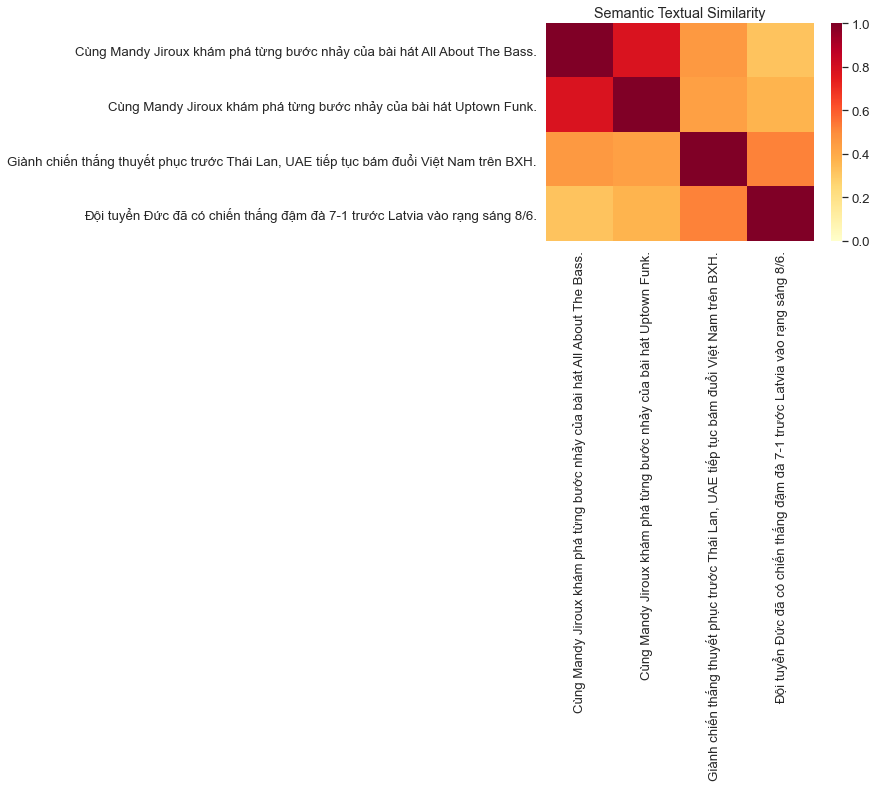

In [10]:
sport_des = [
    'Cùng Mandy Jiroux khám phá từng bước nhảy của bài hát All About The Bass.',
    'Cùng Mandy Jiroux khám phá từng bước nhảy của bài hát Uptown Funk.',
    'Giành chiến thắng thuyết phục trước Thái Lan, UAE tiếp tục bám đuổi Việt Nam trên BXH.',
    'Đội tuyển Đức đã có chiến thắng đậm đà 7-1 trước Latvia vào rạng sáng 8/6.'
]

run_and_plot(sport_des)

In [73]:
'''
Download meta data.
Private code
'''

'\nDownload meta data.\nPrivate code\n'

In [64]:
data_df = data_df[data_df["Description"].str.len()>10]

In [67]:
EMBEDDING_ITEMS = embed(data_df[data_df["Description"].str.len()>10]["Description"].values)
def sport_neighbors(data_df, model, title, k=10):
    idx =  data_df[data_df['Title'].str.contains(title)].index.values
    desc = data_df.iloc[idx]["Description"].values
    if len(idx) == 0:
        raise ValueError("Found no movies with title %s" % title_substring)
    print("Nearest neighbors of : %s." % title)
    embedding_query = model(desc)
    scores = np.dot(embedding_query, tf.transpose(EMBEDDING_ITEMS))[0, :]
    data_df["scores"] = pd.Series(list(scores))
    display.display(data_df[["Title", "SubName", "Description", "scores"]].sort_values(["scores"], ascending=False).head(k))

In [70]:
title_substring = 'Hướng dẫn tập nhảy bài All About That Bass'
sport_neighbors(data_df, embed, title_substring)

Nearest neighbors of : Hướng dẫn tập nhảy bài All About That Bass.


<ipython-input-67-512b4b313068>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["scores"] = pd.Series(list(scores))


,Title,SubName,Description,scores
1,Hướng dẫn tập nhảy bài All About That Bass,Tập luyện Dance,Cùng Mandy Jiroux khám phá từng bước nhảy của ...,1.000
3,Hướng dẫn tập nhảy bài Dear Future Husband,Tập luyện Dance,Cùng Mandy Jiroux khám phá từng bước nhảy của ...,0.712
2,Hướng dẫn nhảy bài Uptown Funk,Tập luyện Dance,Cùng Mandy Jiroux khám phá từng bước nhảy của ...,0.673
5474,Màn trình diễn của Duvan Zapata trước Juventus,Bóng đá Ý,Dù không ghi bàn nhưng Duvan Zapata cũng khiến...,0.637
2920,Đốt cháy tối đa calo trong 2 tuần - phần 2,Tập luyện Fitness,Loại bỏ tối đa lượng calo dư thừa trong cơ thể...,0.637
1751,Tạp chí Full Impact Vòng 03,Tạp chí bóng đá Ý,Atalanta tiếp tục cống hiến màn trình diễn chó...,0.637
1985,Bayern Munich - Frankfurt Highlights,Bóng đá châu Âu,"Với sức mạnh vượt trội cùng lợi thế sân nhà, '...",0.633
1752,Daniel Ricciardo khám phá nước Mỹ trên chiếc F1,Clip Hot,Cùng đồng hành với Daniel Ricciardo trên hành ...,0.633
761,Sportbiz 247 - số 48,Sportbiz 247,Chương trình tổng hợp thông tin về hậu trường ...,0.629
2923,Rewind - Ngày 12/12,Ngược dòng thời gian,Conor McGregor knock out đối thủ chỉ sau 13 gi...,0.625
